In [1]:
import tensorflow as tf

/home/mkk/anaconda3/envs/shelfwise_kk/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../src/")

In [4]:
import tf_optimizer as tf_opt

In [5]:
import sklearn.datasets as sk_datasets

In [677]:
ndims = 100
Q = sk_datasets.make_spd_matrix(ndims).astype(np.float32)
b = np.random.randn(ndims, 1).astype(np.float32)
w0 = np.random.randn(ndims, 1).astype(np.float32)

In [678]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [679]:
def define_problem(w0, Q, b):
    weights = tf.get_variable(
        name='w', 
        dtype=tf.float32, 
        initializer=w0)
    
    w_exact = np.linalg.inv(Q) @ b
    w_exact_norm = np.linalg.norm(w_exact) + 1e-6
    
    # x^T Q x + b^T x
    loss = 0.5 * tf.matmul(tf.transpose(weights), tf.matmul(Q, weights)) \
         - tf.matmul(tf.transpose(b), weights)

    rel_dist = tf.sqrt(tf.reduce_sum(tf.square(weights - w_exact)))/w_exact_norm    
    return loss, rel_dist

In [680]:
loss, rel_dist = define_problem(w0, Q, b)

In [202]:
lr_ph = tf.placeholder(tf.float32, shape=())
with tf.variable_scope('opt'):
    optimizer = tf_opt.NormalizedSGD(lr=lr_ph, lr_update=0.05, lr_max=1.0, lr_min=1e-6, lr_force=-0.4)
#     optimizer = tf_opt.BarzilaiBorweinNormalizedSGD(
#         lr=lr_ph, steps=3, 
#         lr_max=1.0, lr_min=1e-6, 
#         lr_update=0.05,
#         noise_amplitude=0.0)
#     optimizer = tf.train.AdamOptimizer(lr_ph)
#     optimizer = tf.train.MomentumOptimizer(lr_ph, 0.2)
    
update_op = optimizer.minimize(loss)


In [93]:
from tqdm import tqdm
eps = 1e-4
max_iter = 1000
lr_steps = []


In [52]:
for lr_np in tqdm(np.linspace(0.05, 1.5, 50)):
    sess.run(tf.global_variables_initializer(), feed_dict={lr_ph: lr_np})    
    for i in range(max_iter):
        dist, _ = sess.run(
            [rel_dist, update_op], 
            feed_dict={lr_ph: lr_np})
        if np.isinf(dist):
            break
        if dist <= eps:
            lr_steps.append([lr_np, i, dist])   
            break
    if dist > eps or np.isinf(dist):
        lr_steps.append([lr_np, max_iter, dist])

100%|██████████| 50/50 [00:20<00:00,  2.21it/s]


In [ ]:
def fit(loss, feed_dict, max_iter, opt_vars=[]):
    update_op = optimizer.minimize(loss)
    sess.run(tf.global_variables_initializer(), feed_dict=feed_dict)
    hist = []
    for i in range(max_iter):
        output = sess.run(
            [rel_dist, update_op] + opt_vars, 
            feed_dict={lr_ph: lr_np}
        )
        dist, _, opt_vars
        dist = output[0]
        if len(opt_vars) > 0:
            dist = output[-1:]
        if np.isinf(dist):
            break
        if dist <= eps:
            hist.append([lr_np, i, dist])   
            break
    if dist > eps or np.isinf(dist):
        hist.append([lr_np, max_iter, dist])

In [44]:
lr_steps = np.array(lr_steps)


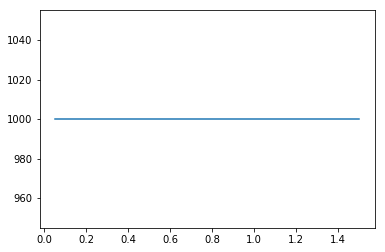

In [45]:
plt.plot(lr_steps[:, 0], lr_steps[:, 1])

In [91]:
# lr_steps

In [76]:
sess.run(optimizer._lr_variables[0])

0.000103796374

In [71]:
optimizer._lr_variables

[<tf.Variable 'w/lr_1:0' shape=() dtype=float32_ref>]

In [72]:
w_exact

array([[  3.8054013 ],
       [  4.3850718 ],
       [ 13.384926  ],
       [-15.287289  ],
       [ -4.543612  ],
       [ 10.745926  ],
       [  2.8218708 ],
       [-17.763622  ],
       [  1.4141669 ],
       [ -5.190056  ],
       [ -6.7260065 ],
       [ -2.9711447 ],
       [  6.783842  ],
       [  5.0283666 ],
       [ -0.08010101],
       [ -9.866516  ],
       [ -2.74928   ],
       [ -3.4458466 ],
       [  4.7724733 ],
       [  7.3328953 ]], dtype=float32)

In [772]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

lr_np = 0.01
lr_steps = []
max_iter = 1000

with tf.variable_scope('opt'):
    optimizer = tf_opt.NormalizedSGD(
        lr=lr_np,
        lr_update=0.02, 
        lr_max=0.5, 
        lr_min=0.0, 
        lr_force=0.000, 
        momentum=0.9,
        momentum_update=0.002,
        norm='std', 
        noise_amplitude=0.0
    )

    loss, rel_dist = define_problem(w0, Q, b)
update_op = optimizer.minimize(loss)

try:
    opt_vars = optimizer._lr_variables + optimizer._m_variables + [optimizer.test]
except:
    opt_vars = [-rel_dist, -rel_dist*0, -rel_dist*0]


sess.run(tf.global_variables_initializer())    
for i in range(max_iter):
    dist, loss_np, _, *lr_ada = sess.run([rel_dist, loss, update_op] + opt_vars)        
    lr_steps.append([i, loss_np[0][0], dist, *lr_ada])   
lr_steps = np.array(lr_steps)
# lr_steps

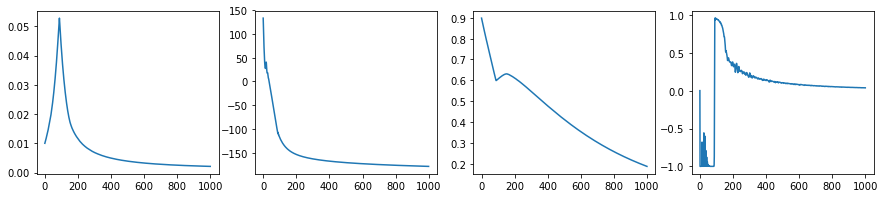

In [773]:
plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.plot(lr_steps[:, 0], lr_steps[:, 3])
plt.subplot(142)
plt.plot(lr_steps[:, 0], lr_steps[:, 1])
plt.subplot(143)
plt.plot(lr_steps[:, 0], lr_steps[:, -2])
plt.subplot(144)
plt.plot(lr_steps[:, 0], lr_steps[:, -1])

In [140]:


def fit(optimizer, scope):
    history = []
    max_iter = 1000
    with tf.variable_scope(scope):
        loss, rel_dist = define_problem(w0, Q, b)
        update_op = optimizer.minimize(loss)
        sess.run(tf.global_variables_initializer())    
        
    for i in range(max_iter):
        _= sess.run([update_op])        
        loss_np = sess.run(loss) 
        history.append([i, loss_np])   
    history = np.array(history)
    return history

In [766]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

lr_np = 0.001

optimizer = tf_opt.NormalizedSGD(
    lr=0.001,
    lr_update=0.05, 
    lr_max=0.5, 
    lr_min=0.0001, 
    lr_force=0.0, 
    momentum=0.9,
    momentum_update=0.00001,
    norm='std', 
    noise_amplitude=0.0)

tf_optimizer = tf_opt.NormalizedSGD(
    lr=0.1,
    lr_update=0.05, 
    lr_max=0.5, 
    lr_min=0.0001, 
    lr_force=0.000, 
    momentum=0.9,
    momentum_update=0.0001,
    norm='l2', 
    noise_amplitude=0.0)

# from tensorflow.contrib.opt.python.training import nadam_optimizer
# tf_optimizer = tf.train.MomentumOptimizer(lr_np, momentum=0.9)
# tf_optimizer = tf.train.AdamOptimizer(lr_np, beta1=0.9)
# tf_optimizer = tf.train.RMSPropOptimizer(lr_np, decay=0.9, momentum=0.9)
# tf_optimizer = nadam_optimizer.NadamOptimizer(lr_np)

hist_normed = fit(optimizer, 'normed')
hist_sgd = fit(tf_optimizer, 'sgd')

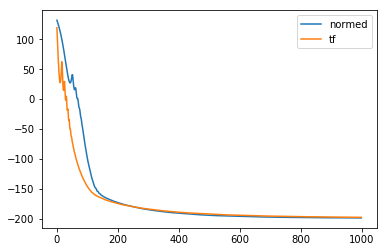

In [767]:
plt.plot(hist_normed[:, 0], hist_normed[:, 1], label='normed')
plt.plot(hist_sgd[:, 0], hist_sgd[:, 1], label='tf')
# plt.ylim([hist_sgd[-1, 1], hist_sgd[200, 1]])
plt.legend()